# Examining Influential Factors on Poverty Status
## Logistic Regression Modeling

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


pd.set_option('display.max_rows', None)

In [2]:
#read from github repository
df = pd.read_csv("https://media.githubusercontent.com/media/Rpierre98/DSI-320-Group-Project/main/data/clean_data/cleaned_data.csv")
df.head()

,AGE,STATE,FAM_RELATIONSHIP,OUT_POCKET_NONPREM,OUT_POCKET_OC,OCCUPATION,EDU_LVL,MARITAL,SEX,HOUSEHOLD_SUMMARY,...,CASH_ASSIST,WIC,CHLD_SUP,ADJ_GROSS_INC,TAX_FILE_STAT,HEALTH_INS,PUB_INS,PRIV_INS,POV_STS,POV_LVL
0,42,nonmover,not fam,0,0,Professional,associate degree,single,male,householder,...,under 15,not eligible,0,44220,single,yes,no coverage,covered all year,0,150+ percent of poverty level
1,62,nonmover,ref person,320,48,Business/Finance,high school graduate,married/civilian spouse,male,householder,...,under 15,not eligible,0,80349,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
2,64,nonmover,spouse,0,100,Professional,bachelor's degree,married/civilian spouse,female,spouse of HH,...,under 15,not eligible,0,0,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
3,26,nonmover,ref person,0,100,sales,college no degree,married/civilian spouse,male,householder,...,under 15,not eligible,0,60001,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
4,24,nonmover,spouse,300,100,Professional,college no degree,married/civilian spouse,female,spouse of HH,...,under 15,no,0,0,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level


## Basic Logistic Regression

In [3]:
#dropping columns not used in modeling
df=df.drop(columns=['HOUSEHOLD_SUMMARY',
 'MILITARY',
 'CERT_REQ',
 'TROUB_BATHE',
 'TROUB_HEAR',
 'TROUB_SEE',
 'TROUB_ALONE',
 'TROUB_WALK',
 'TROUB_CONC','DIS_INC',
 'OTH_DIS_INC','POV_LVL','GROSS_PAY','ADJ_GROSS_INC'])

In [4]:
#making categorical columns into df
categorical_columns = df.select_dtypes(include='object')
categorical=pd.DataFrame(categorical_columns)

In [5]:
categorical.head()

,STATE,FAM_RELATIONSHIP,OCCUPATION,EDU_LVL,MARITAL,SEX,HISPANIC,IMMIGR_YR,CITIZENSHIP,DISABLED,...,ERN_OTR,WORK_DIS,FIN_ASSIST,OTH_INC,CASH_ASSIST,WIC,TAX_FILE_STAT,HEALTH_INS,PUB_INS,PRIV_INS
0,nonmover,not fam,Professional,associate degree,single,male,no,not immigrant,native,no,...,no,no,no,no other source,under 15,not eligible,single,yes,no coverage,covered all year
1,nonmover,ref person,Business/Finance,high school graduate,married/civilian spouse,male,no,not immigrant,native,no,...,yes,no,no,anything else,under 15,not eligible,joint under 65 y/o,yes,no coverage,covered all year
2,nonmover,spouse,Professional,bachelor's degree,married/civilian spouse,female,no,not immigrant,native,yes,...,no,no,no,no other source,under 15,not eligible,joint under 65 y/o,yes,no coverage,covered all year
3,nonmover,ref person,sales,college no degree,married/civilian spouse,male,no,not immigrant,native,no,...,no,no,no,no other source,under 15,not eligible,joint under 65 y/o,yes,no coverage,covered all year
4,nonmover,spouse,Professional,college no degree,married/civilian spouse,female,no,not immigrant,native,no,...,no,yes,no,no other source,under 15,no,joint under 65 y/o,yes,no coverage,covered all year


In [6]:
#making numerical columns into df
numeric_columns = df.select_dtypes(include=np.number)
numeric= pd.DataFrame(numeric_columns)

In [7]:
#encoding numerical data
ohe = OneHotEncoder()

encoded = ohe.fit_transform(categorical).toarray()

encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out())

#concating dfs
new_df= pd.concat([encoded_df, numeric], axis=1)

In [8]:
new_df.head()

,STATE_ Arizona,STATE_Abroad,STATE_Alabama,STATE_Alaska,STATE_Arkansas,STATE_California,STATE_Colorado,STATE_Connecticut,STATE_Delaware,STATE_District of Columbia,...,PRIV_INS_some coverage,AGE,OUT_POCKET_NONPREM,OUT_POCKET_OC,WEEKS_WRK,EARN_TOTAL,TOTAL_DIS_INC,TIME_ASSIST,CHLD_SUP,POV_STS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,42,0,0,52,44200,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,62,320,48,38,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,64,0,100,52,48000,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26,0,100,52,40000,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24,300,100,44,20000,0,0,0,0


In [9]:
new_df.columns

Index(['STATE_ Arizona', 'STATE_Abroad', 'STATE_Alabama', 'STATE_Alaska',
       'STATE_Arkansas', 'STATE_California', 'STATE_Colorado',
       'STATE_Connecticut', 'STATE_Delaware', 'STATE_District of Columbia',
       ...
       'PRIV_INS_some coverage', 'AGE', 'OUT_POCKET_NONPREM', 'OUT_POCKET_OC',
       'WEEKS_WRK', 'EARN_TOTAL', 'TOTAL_DIS_INC', 'TIME_ASSIST', 'CHLD_SUP',
       'POV_STS'],
      dtype='object', length=278)

In [10]:
#baseline
new_df['POV_STS'].value_counts(normalize=True)

0    0.927009
1    0.072991
Name: POV_STS, dtype: float64

very imbalanced classes

In [11]:
#defining x and y
X=new_df.drop(columns=['POV_STS'])
y= new_df['POV_STS']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

#scaling
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [12]:
lr= LogisticRegression(max_iter=1000)
lr.fit(Z_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
#predicting poverty classification
y_pred = lr.predict(Z_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
accuracy = lr.score(Z_test, y_test)
accuracy

0.9301077028840803

In [15]:
bac= balanced_accuracy_score(y_test,y_pred)
bac

0.547326757556308

In [16]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

cm = confusion_matrix(y_test, y_pred)

cmdisplay = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=lr.classes_)

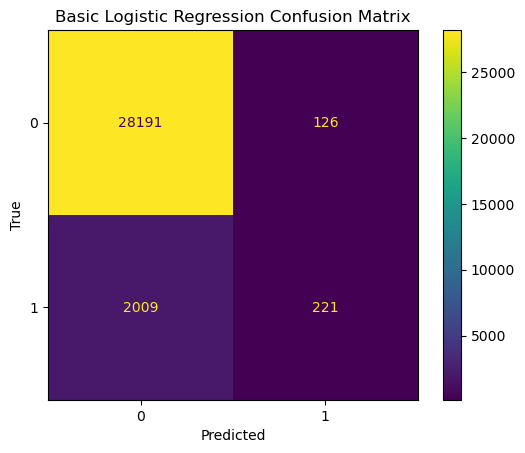

In [18]:
cmdisplay.plot()
plt.title('Basic Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('../images/classification_models/lr1_cm.png')

In [19]:
#f1 score
f1_score(y_test,y_pred)

0.1715172681412495

In [20]:
np.exp(lr.coef_)

array([[1.01731685e+00, 1.02722381e+00, 1.02966849e+00, 1.00047663e+00,
        9.98746767e-01, 1.02982105e+00, 9.99060550e-01, 1.00603099e+00,
        1.02585608e+00, 9.64440196e-01, 1.00842843e+00, 9.96366631e-01,
        9.98954049e-01, 1.00019703e+00, 9.95343050e-01, 1.01108812e+00,
        1.00901096e+00, 9.95197439e-01, 1.01486065e+00, 1.01157974e+00,
        1.00685839e+00, 1.02089889e+00, 9.59706209e-01, 1.02057695e+00,
        9.94116319e-01, 9.90483509e-01, 9.95336976e-01, 9.91930824e-01,
        9.65648305e-01, 9.87720792e-01, 1.03891952e+00, 1.01936786e+00,
        9.96785125e-01, 9.95368370e-01, 1.00022608e+00, 9.96147134e-01,
        1.00567485e+00, 9.96966910e-01, 9.91441333e-01, 1.03395231e+00,
        9.99346705e-01, 9.99628914e-01, 9.52657135e-01, 1.00745043e+00,
        9.85970254e-01, 1.00436358e+00, 1.00127955e+00, 9.94653852e-01,
        1.01498876e+00, 1.00594553e+00, 1.01291842e+00, 1.02153932e+00,
        9.75767741e-01, 6.23830615e-01, 1.40898691e+00, 9.538745

In [21]:
# Series with coefs
coef_series = pd.Series(np.exp(lr.coef_[0]), index=X_train.columns.tolist())

# Sort the coefficients in descending order by absolute value
sorted_coef = coef_series.abs().sort_values(ascending=False)


#dataframe 
pd.DataFrame(sorted_coef)

,0
MARITAL_married/civilian spouse,2.612808
TAX_FILE_STAT_nonfiler,2.305828
TAX_FILE_STAT_single,1.818369
FAM_RELATIONSHIP_not fam,1.408987
TAX_FILE_STAT_head of HH,1.363038
PRIV_INS_no coverage,1.188612
OUT_POCKET_NONPREM,1.177413
FAM_RELATIONSHIP_ref person,1.162689
WEEKS_WRK,1.150680
CHLD_SUP,1.128718


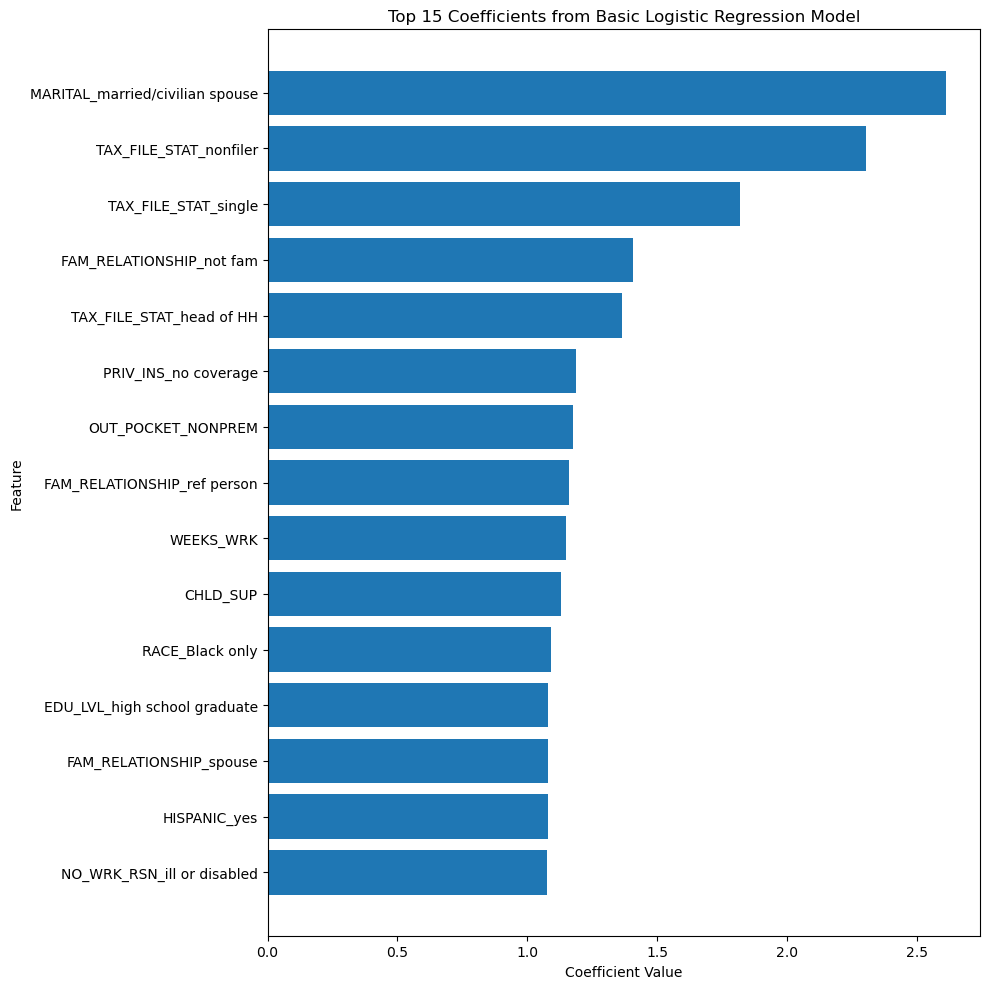

In [35]:
top15=sorted_coef.head(15).sort_values()
plt.figure(figsize=(10,10))
plt.barh(top15.index, top15.values)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Coefficients from Basic Logistic Regression Model')
plt.tight_layout()
plt.savefig('../images/classification_models/lr_coef1.png')

## Logistic Regression Pipeline

In [24]:
#creating a pipeline
pipeline = Pipeline([
    ('ss',StandardScaler()),
    ('logreg',LogisticRegression(penalty= None, max_iter=1000))  
])
#fitting
pipeline.fit(Z_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, penalty=None))])

In [25]:
# Predict the target variable for the test data
y_pred2 = pipeline.predict(Z_test)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# Evaluate the model
accuracy2 = pipeline.score(Z_test, y_test)
accuracy2

0.9301404393230105

In [27]:
#score on training set
pipeline.score(Z_train, y_train)

0.9305479395997872

The accuracy scores for both the test and train sets are very close indicating that the model is fitting and generalizing well for only the majority class. It also indicates high accuracy. 

In [28]:
#import balanced accuracy
bac2=balanced_accuracy_score(y_test,y_pred2)
bac2

0.5479640888208148

The balanced accuracy scores suggest that the models are both slightly better than just guessing. 

In [29]:
#f1 score
f1_score(y_test,y_pred2)

0.17350890782339268

The f1 score is relatively low for both logistic regression models indicating that there is a low balance between precision and recall and the model struggles to accurately classify the classes.

In [30]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()

cm = confusion_matrix(y_test, y_pred2)

cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=pipeline.classes_)

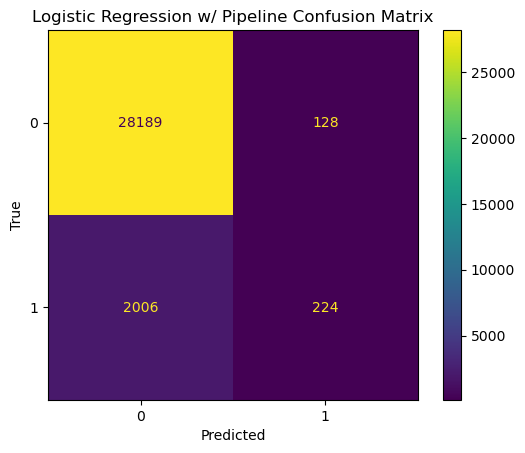

In [31]:
cmdisp.plot()
plt.title('Logistic Regression w/ Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('../images/classification_models/lr2_cm.png')

For both of the models, the confusion matrix is correctly predicting over 28,000 observations. There are about 2000 false negatives and this is consistent for both of the models with the pipeline barely performing better. There were about 130 false positives for each of the models. In general, the confusion matrix did well but the poverty class is very small.

In [32]:
coef=np.exp(pipeline.named_steps['logreg'].coef_)

In [33]:
# Series with coefs
coef_series2 = pd.Series(np.exp(pipeline.named_steps['logreg'].coef_[0]), index=X_train.columns.tolist())

# Sort coefs
sorted_coef2 = coef_series2.abs().sort_values(ascending=False)

#dataframe 
pd.DataFrame(sorted_coef2)

,0
MARITAL_married/civilian spouse,2.691303
TAX_FILE_STAT_nonfiler,2.346228
TAX_FILE_STAT_single,1.850657
FAM_RELATIONSHIP_not fam,1.410653
TAX_FILE_STAT_head of HH,1.375809
PRIV_INS_no coverage,1.188648
WEEKS_WRK,1.186783
OUT_POCKET_NONPREM,1.178212
FAM_RELATIONSHIP_ref person,1.162761
CHLD_SUP,1.130723


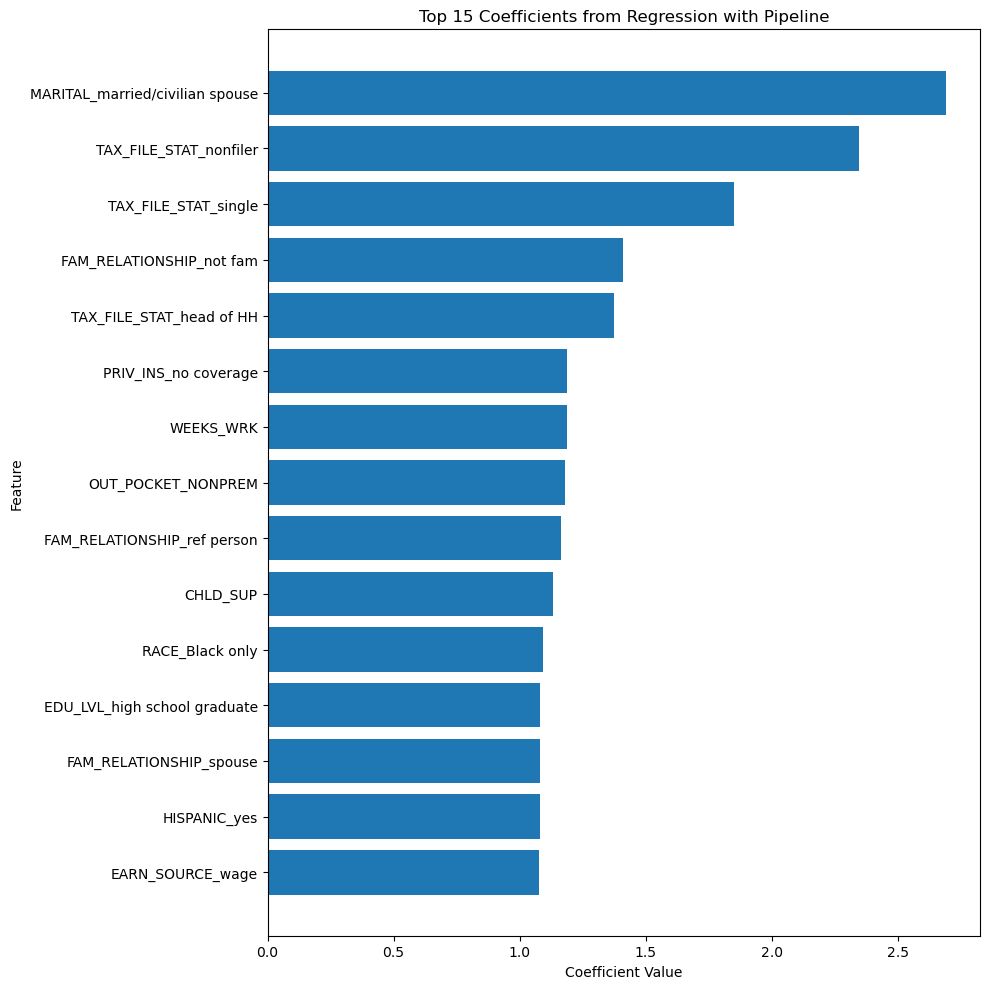

In [34]:
topfif=sorted_coef2.head(15).sort_values()
plt.figure(figsize=(10,10))
plt.barh(topfif.index, topfif.values)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Coefficients from Regression with Pipeline')
plt.tight_layout()
plt.savefig('../images/classification_models/lr_coef2.png')


Unexpectedly, the coefficient for married people with civilian spouses was the highest indicating that they are the most likely to be labeled as impoverished.   In terms of tax filing status, those who didnt file at all and single filers have the second and third highest coefficient in the models while those who file jointly have the lowest coefficients in the model besides the coefficient for total earnings. 

People who identified as black only had the highest coefficient out of the all races and people who identified as hispanic also had a high coeffiecient of 1.079807. 

Those whose highest level of education achieved is high school have the highest coefficient out of all of the education levels indicating that people with only a high school diploma are most likely to be labeled impoverished. Surprisingly, it was higher than the coefficient for those with only some high school.  

People with no private insurance coverage have the highest coefficients out of all of the health insurance coverage features.